# My Model Save & Load
---
## Easy, but Important!

### Keras Update

In [1]:
!pip install keras-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.6 MB/s eta 0:00:00


### Library Loading

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import keras

from keras.backend import clear_session
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import RandomRotation, RandomTranslation, RandomFlip, RandomZoom
from keras.callbacks import EarlyStopping

## Data Loading

In [3]:
(train_x, train_y), (test_x, test_y) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


* 데이터 살펴보기

id = 5338
다음 그림은 숫자 2 입니다.


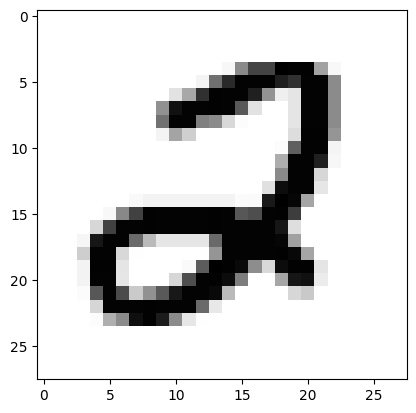

In [5]:
id = np.random.randint(0, 10000)

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y[id]} 입니다.')

plt.imshow(test_x[id], cmap='Greys')
plt.show()

## Data Preprocessing

* Data split
    - training set : validation set = 8 : 2
    - 재현을 위한 난수 고정 : 2024

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_x, val_x, train_y, val_y =\
    train_test_split(train_x, train_y, test_size=0.2, random_state=2024)

In [8]:
train_x.shape, train_y.shape

((48000, 28, 28), (48000,))

* Scaling
    - min-max scaling

In [9]:
train_x = train_x / 255.
val_x = val_x / 255.
test_x = test_x / 255.

In [10]:
train_x.max(), train_x.min()

(1.0, 0.0)

* One-Hot Encoding

In [11]:
from keras.utils import to_categorical

In [12]:
train_y = to_categorical(train_y, 10)
val_y = to_categorical(val_y, 10)
test_y = to_categorical(test_y, 10)

* 흑백 정보를 명시하기 위한 reshape

In [13]:
train_x = train_x.reshape((-1, 28, 28, 1))
val_x = val_x.reshape((-1, 28, 28, 1))
test_x = test_x.reshape((-1, 28, 28, 1))

In [14]:
train_x.shape, train_y.shape

((48000, 28, 28, 1), (48000, 10))

## Modeling : CNN

- 조건
    1. Sequential API, Functiona API 중 택일.
    2. Image Augmentation Layer를 최소 하나 이상 넣을 것! : [공식 문서 참고](https://keras.io/api/layers/preprocessing_layers/)
    3. [이 구조를 미니 버전으로 활용해봐도 좋다.](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99DFA5415B38AC752E)
    4. DropOut, BatchNormalization 등의 기능도 같이 활용해보자.
    5. Early Stopping을 사용할 것.

In [17]:
## Sequential API
# 1. 세션 클리어
clear_session()

# 2. 모델 선언 및 레이어 조립
model = Sequential([Input(shape=(28,28,1)),
                    ######################
                    # Augmentation Layer
                    RandomFlip('horizontal'),
                    RandomZoom(0.1),
                    RandomTranslation(0.1, 0.1),
                    ######################
                    Conv2D(64, 3, 1, 'same', activation='relu'),
                    Conv2D(64, 3, 1, 'same', activation='relu'),
                    MaxPool2D(2),
                    BatchNormalization(),
                    Dropout(0.3),
                    Conv2D(128, 3, 1, 'same', activation='relu'),
                    Conv2D(128, 3, 1, 'same', activation='relu'),
                    MaxPool2D(2),
                    BatchNormalization(),
                    Dropout(0.3),
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dense(10, activation='softmax'),
                    ])

# 요약
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 28, 28, 1)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,868,234 (7.13 MB)

 Trainable params: 1,867,850 (7.13 MB)

 Non-trainable params: 384 (1.50 KB)

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

* Early Stopping

In [19]:
es = EarlyStopping(patience=3, verbose=1, restore_best_weights=True)

* **Model Checkpoint**

In [20]:
###########################################
from keras.callbacks import ModelCheckpoint
###########################################

In [21]:
############################################################################################
mcp = ModelCheckpoint(filepath='./model1.keras',       # 모델 저장 경로
                      monitor='val_loss',              # 모델 저장의 관심 대상
                      verbose=1,                       # 어느 시점에서 저장되는지 알려줌
                      save_best_only=True,             # 최고 성능 모델만 저장
                      save_weights_only=False)         # True : 가중치만 저장| False : 모델 구조 포함하여 저장
#############################################################################################

* .fit( )

In [22]:
history = model.fit(train_x, train_y, validation_data=(val_x, val_y),
                    epochs=10000, verbose=1,
                    callbacks=[es, mcp]
                    )

Epoch 1/10000
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8061 - loss: 0.6195
Epoch 1: val_loss improved from inf to 0.23777, saving model to ./model1.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.8063 - loss: 0.6191 - val_accuracy: 0.9327 - val_loss: 0.2378
Epoch 2/10000
1496/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9599 - loss: 0.1338
Epoch 2: val_loss improved from 0.23777 to 0.10443, saving model to ./model1.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.9599 - loss: 0.1337 - val_accuracy: 0.9707 - val_loss: 0.1044
Epoch 3/10000
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9659 - loss: 0.1101
Epoch 3: val_loss improved from 0.10443 to 0.08523, saving model to ./model1.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9659 - loss: 0.1101 - val_accuracy: 0.9735 - val_loss: 0.0852
Epoch 4/10000
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9719 - loss: 0.0963
Epoch 4: val_loss improv

In [23]:
performance_test = model.evaluate(test_x, test_y)

print(f'Test Loss: {performance_test[0]:.6f}')
print(f'Test Accuracy: {performance_test[1]*100:.3f}%')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9853 - loss: 0.0521
Test Loss: 0.038590
Test Accuracy: 98.830%


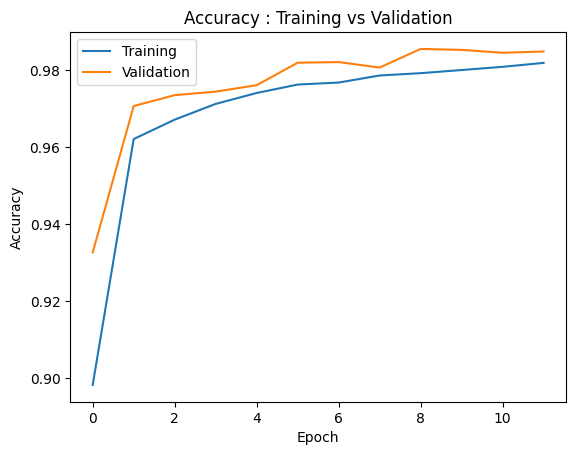

In [24]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

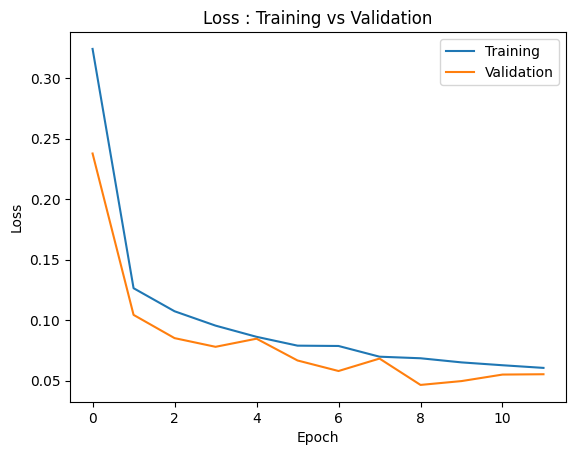

In [25]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

## **Model Save & Load**

- .save( )
- .load_model( )

* 모델을 새롭게 저장하여 구조와 가중치 일부를 살펴보자

In [26]:
model.save('./my_first_save.keras')

In [ ]:
keras.utils.clear_session()

model3 = keras.saving.load_model('./my_first_save.keras')
model3.summary()

In [28]:
model3.get_weights()[0][0][0]

array([[-0.19578007, -0.0078256 ,  0.00449818, -0.06137608, -0.18199001,
        -0.19215378,  0.07135831, -0.15595144, -0.05431284,  0.04039201,
        -0.12783132, -0.09870891, -0.34936538, -0.00326559,  0.00591939,
        -0.19049746,  0.00341904,  0.13434783,  0.01348327, -0.0017281 ,
         0.20343493, -0.19263086,  0.18069918, -0.2341393 ,  0.06060618,
        -0.11414709, -0.03009805, -0.18176961, -0.08532466,  0.00832732,
        -0.28654128, -0.05983621, -0.06594244,  0.09586045, -0.07037544,
        -0.24779736,  0.08318204, -0.3378885 ,  0.14644577,  0.07204581,
        -0.16131046,  0.11645792, -0.02553329, -0.02081743, -0.07882186,
        -0.10080477,  0.31325322, -0.07841808, -0.07353519, -0.33290958,
         0.1575371 , -0.12702003,  0.16490908, -0.00307817, -0.09417231,
         0.2061232 ,  0.12484283,  0.00799985,  0.10620478, -0.20704708,
        -0.09599061,  0.0599148 ,  0.1371583 ,  0.01745762]],
      dtype=float32)

* 학습 과정에서 저장된 모델을 불러와 구조와 가중치 일부를 살펴보자

In [ ]:
keras.utils.clear_session()

model = keras.saving.load_model('./model1.keras')
model.summary()

In [30]:
model.get_weights()[0][0][0]

array([[-0.19578007, -0.0078256 ,  0.00449818, -0.06137608, -0.18199001,
        -0.19215378,  0.07135831, -0.15595144, -0.05431284,  0.04039201,
        -0.12783132, -0.09870891, -0.34936538, -0.00326559,  0.00591939,
        -0.19049746,  0.00341904,  0.13434783,  0.01348327, -0.0017281 ,
         0.20343493, -0.19263086,  0.18069918, -0.2341393 ,  0.06060618,
        -0.11414709, -0.03009805, -0.18176961, -0.08532466,  0.00832732,
        -0.28654128, -0.05983621, -0.06594244,  0.09586045, -0.07037544,
        -0.24779736,  0.08318204, -0.3378885 ,  0.14644577,  0.07204581,
        -0.16131046,  0.11645792, -0.02553329, -0.02081743, -0.07882186,
        -0.10080477,  0.31325322, -0.07841808, -0.07353519, -0.33290958,
         0.1575371 , -0.12702003,  0.16490908, -0.00307817, -0.09417231,
         0.2061232 ,  0.12484283,  0.00799985,  0.10620478, -0.20704708,
        -0.09599061,  0.0599148 ,  0.1371583 ,  0.01745762]],
      dtype=float32)

* .predict( )

In [31]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)

single_pred_train = pred_train.argmax(axis=1)
single_pred_test = pred_test.argmax(axis=1)

logi_train_accuracy = accuracy_score(train_y.argmax(axis=1), single_pred_train)
logi_test_accuracy = accuracy_score(test_y.argmax(axis=1), single_pred_test)

print('CNN')
print(f'트레이닝 정확도 : {logi_train_accuracy*100:.2f}%')
print(f'테스트 정확도 : {logi_test_accuracy*100:.2f}%')

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN
트레이닝 정확도 : 98.83%
테스트 정확도 : 98.83%


## Visualization

* 실제 데이터 확인

id = 3658
다음 그림은 숫자 2 입니다.
모델의 예측 : 2
모델의 카테고리별 확률 : [ 0.  0. 99.  0.  0.  0.  0.  0.  0.  0.]
정답입니다


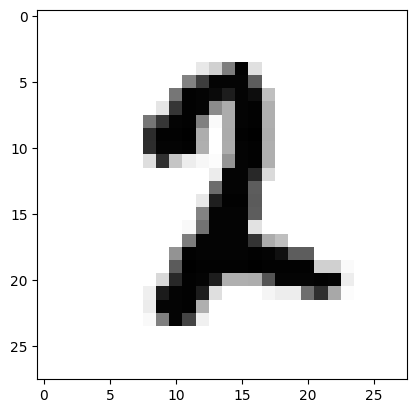

In [32]:
'''
성능 확인을 위해
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = np.random.randint(0,10000)

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y.argmax(axis=1)[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y.argmax(axis=1)[id] == single_pred_test[id] :
    print('정답입니다')
else :
    print('틀렸어요')

plt.imshow(test_x[id].reshape([28,-1]), cmap='Greys')
plt.show()

* 틀린 이미지만 확인해보기

id = 2195
다음 그림은 숫자 7 입니다.
모델의 예측 : 5
모델의 카테고리별 확률 : [ 0.  0. 13.  0.  0. 80.  0.  6.  0.  0.]
틀렸어요


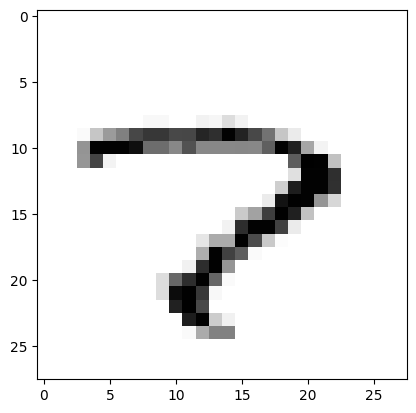

In [33]:
true_false = (test_y.argmax(axis=1) == single_pred_test)
f_id = np.where(true_false == False)[0]
f_n = len(f_id)

id = f_id[np.random.randint(0,f_n)]

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y.argmax(axis=1)[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y.argmax(axis=1)[id] == single_pred_test[id] :
    print('정답입니다')
else :
    print('틀렸어요')

plt.imshow(test_x[id].reshape([28,-1]), cmap='Greys')
plt.show()

# **내가 만든 손글씨 이미지는 어떻게 판단할까?**
---
## **구글 드라이브에 손글씨 이미지를 업로드!**
###**순서**
1. 그림판으로 숫자를 그려서 저장한다.
2. 구글 드라이브 첫 화면에 my_data 라는 폴더를 만든다.
3. my_data 폴더 안에 my_mnist 폴더를 만든다.
4. my_mnist 폴더 안에 1번 과정에서 만든 이미지를 업로드한다.
5. 30초 정도 기다립시다.
6. 아래의 코드들을 실행해본다.

## Connect Colaboratory with my Google Drive
- Colaboratory와 본인의 구글 드라이브를 연결하는 과정
- 아래 코드를 실행하여 폴더가 올바르게 생성 되었는지 확인

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
!ls

drive  model1.keras  my_first_save.keras  sample_data


In [36]:
!cd /content/drive/MyDrive/my_data; ls

datasets  img1	model1.keras  my_first_save.h5	   my_mnist   MyPjt  transfer
handmade  img2	model.png     my_first_save.keras  my_mnist2  temp


## Load Image
- 업로드 한 이미지 하나를 불러와 확인해본다

In [37]:
import glob
from keras.preprocessing import image

In [38]:
files = glob.glob('/content/drive/MyDrive/my_data/my_mnist/*')
files

['/content/drive/MyDrive/my_data/my_mnist/2_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/3_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/4_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/5_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/6_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/7_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/8_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/9_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/0_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/1_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/2_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/7_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/9_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/8_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/0_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/1_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/3_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/4_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/5_2.png',
 '/content/d

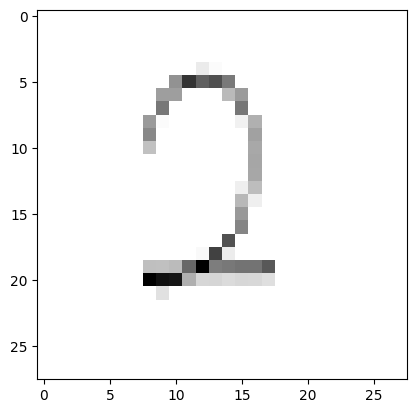

In [39]:
img = image.load_img(files[0], color_mode='grayscale', target_size=(28,28) )
img = image.img_to_array(img)

plt.imshow(img.reshape(img.shape[0], img.shape[1]), cmap='gray')
plt.show()

In [40]:
img = 255-img

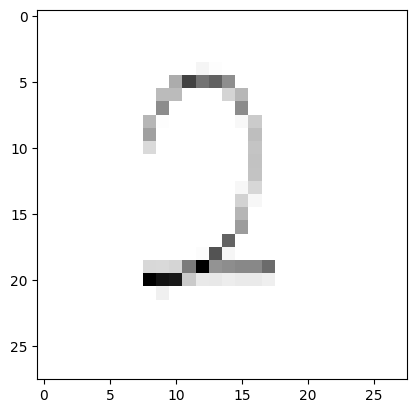

In [41]:
plt.imshow(img.reshape(img.shape[0],img.shape[1]), cmap='Greys'  )
plt.show()

In [42]:
model.predict(img.reshape((-1,28,28,1)))[0].argmax()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


2

## Load Images
- 업로드 한 이미지 전체를 확인해본다

In [46]:
images = []

for path in files :
    img = image.load_img(path, color_mode='grayscale', target_size=(28,28) )
    img = image.img_to_array(img)
    # img = 255-img
    images.append(img)

images = np.array(images)

In [47]:
images.shape

(80, 28, 28, 1)

In [ ]:
pred = model.predict(images)

for i in range(images.shape[0]) :
    print('====================================')
    print(f'모델의 예측 : {pred[i].argmax()}')
    print(f'모델의 카테고리별 확률 : {np.floor(pred[i]*100)}')

    plt.imshow(images[i].reshape(28,28) , cmap='Greys')
    plt.show()

---

# Extra: image_dataset_from_directory
## 이미 내가 이미지 데이터를 클래스별로 정리한 상태라면?
---
## **순서**
1. 구글 드라이브에 my_data/my_mnist2 폴더를 생성합니다.
2. my_mnist2 폴더 안에 손글씨가 폴더별로 구분되어야 한다.
    - ex) 0에 대한 이미지면 my_data/my_mnist2/0/0_1.jpg
    - ex) 1에 대한 이미지면 my_data/my_mnist2/1/1_1.jpg

In [49]:
from keras.utils import image_dataset_from_directory
# from keras.preprocessing.image import image_dataset_from_directory

In [50]:
# idfd_train, idfd_valid = image_dataset_from_directory('/content/drive/MyDrive/my_data/my_mnist2',
#                                                       label_mode='categorical',
#                                                       color_mode='grayscale',
#                                                       image_size=(28,28),
#                                                       seed=2024,
#                                                       validation_split=0.2,
#                                                       subset='both'
#                                                       )

idfd_train = image_dataset_from_directory('/content/drive/MyDrive/my_data/my_mnist2',
                                                      label_mode='categorical',
                                                      color_mode='grayscale',
                                                      image_size=(28,28),
                                                      )

Found 10 files belonging to 10 classes.


In [51]:
keras.utils.clear_session()

model5 = keras.models.load_model('./model1.keras')

# model5.summary()

In [52]:
model5.fit(idfd_train,
        #    validation_data=idfd_valid,
           epochs=1, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2000 - loss: 13.9838


In [53]:
images = []

for path in files :
    img = image.load_img(path, color_mode='grayscale', target_size=(28,28) )
    img = image.img_to_array(img)
    # img = 255-img
    images.append(img)

images = np.array(images)

In [54]:
images.shape

(80, 28, 28, 1)

In [ ]:
pred = model5.predict(images)

for i in range(images.shape[0]) :
    print('====================================')
    print(f'모델의 예측 : {pred[i].argmax()}')
    print(f'모델의 카테고리별 확률 : {np.floor(pred[i]*100)}')

    plt.imshow(images[i].reshape(28,28) , cmap='Greys')
    plt.show()